# 選んだテーマ
参考テーマの課題番号003「葉の状態から植物の病名を識別」を題材とする。
kaggle: https://www.kaggle.com/c/plant-pathology-2020-fgvc7

## 工夫点
- フルスクラッチで学習するのを避けて、ファインチューニングと転移学習の比較を行ってみた点
- classification_report、confusion_matrixを用いて結果の可視化・分析を行った点

In [1]:
# kaggle APIをインストール
!pip install --upgrade --force-reinstall --no-deps kaggle

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     |████████████████████████████████| 58 kB 8.8 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=7c6fb9a3f603b93f92bca30fa94aca9f810dadb0077866081f470bfd4c6cad99
  Stored in directory: /home/ubuntu/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle


In [2]:
# APIキー（kaggle.json）をアップロード
# Google Colabの場合は下記のコメントアウトを解除してkeggle.jsonをアップロード
# それ以外の環境では~/.kaggleディレクトリにkaggle.jsonを配置してchmod 600 ~/.kaggle/kaggle.json

#from google.colab import files

#uploaded = files.upload()

#for fn in uploaded.keys():
#  print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
#!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

ModuleNotFoundError: No module named 'google.colab'

In [10]:
# コンペのデータをダウンロードして展開
#!kaggle competitions download -c plant-pathology-2020-fgvc7
#!unzip  plant-pathology-2020-fgvc7.zip

In [6]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import logging
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd

tqdm.pandas()
import datetime

plt.ion()  # interactive mode


Matplotlib is building the font cache; this may take a moment.


In [7]:
class ImageTransform:
    def __init__(self, resize, mean, std):
        self.data_transform = {
            "train": transforms.Compose(
                [
                    # 訓練時のみデータオーグメンテーション
                    transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "val": transforms.Compose(
                [
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
            "test": transforms.Compose(
                [
                    transforms.Resize(resize),
                    transforms.CenterCrop(resize),
                    transforms.ToTensor(),
                    transforms.Normalize(mean, std),
                ]
            ),
        }

    def __call__(self, img, phase="train") -> None:
        return self.data_transform[phase](img)


In [9]:
class PlantDataset(Dataset):
    def __init__(self, csv, transformer=None, phase="train"):
        self.data = csv
        self.transformer = transformer
        self.phase = phase
        self.labels = torch.eye(4)[self.data["Target"]]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = Image.open("./images/" + self.data.loc[idx]["image_id"] + ".jpg")
        image = self.transformer(image, phase=self.phase)
        labels = torch.tensor(self.data.loc[idx]["Target"])
        return image, labels


In [21]:
def train_model(model, dataloaders, dataset_sizes, device, criterion, optimizer, scheduler, num_epochs=25):
    # 開始時刻
    since = time.time()

    # 最良モデル保存用
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # train/valでモードを切り替える
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 画像ごとにイテレーション
            for inputs, labels in dataloaders[phase]:
                # 入力画像
                inputs = inputs.to(device)
                # 正解ラベル
                labels = labels.to(device)

                # 勾配の初期化
                optimizer.zero_grad()

                # forward
                # 訓練時のみ勾配計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 訓練時のみ誤差逆伝播・パラメータ更新
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # lossと正解率の計算
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 訓練時のみ学習率を変化させる
            if phase == 'train':
                scheduler.step()

            # エポックごとのlossと正解率の計算 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # 最良モデルの更新
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 最良のモデルを戻り値として返す
    model.load_state_dict(best_model_wts)
    return model


In [49]:
def predict(model, dataloader, class_names):
    
    model.eval()

    # 予測
    pred = []
    # 正解
    actual = []
    probabilities = None
    for i, (inputs, labels) in enumerate(dataloader):
        
        # 入力画像
        inputs = inputs.to(device)
        # 正解ラベル
        labels = labels.to(device)

        with torch.no_grad():
            output = model(inputs)

        # softmaxの計算を行う
        softmax_num = F.softmax(output, dim=1)

        p = [int(l.argmax()) for l in softmax_num]
        pred += p

        ly = [int(l) for l in labels]
        actual += ly

    report = classification_report(actual, pred, target_names=class_names)
    print(report)
    cm = confusion_matrix(actual, pred)
    print(cm)


In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [24]:
def visualize_model(model, dataloaders, class_names, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                title = f'label: {class_names[labels[j].int()]}, predicted: {class_names[preds[j]]}'
                ax.set_title(title)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [25]:
# データセット・データローダの用意
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

df = pd.read_csv("./train.csv")
# one-hot表現をラベル表現に変換する
columns = ["healthy", "multiple_diseases", "rust", "scab"]
target = []
for i in tqdm(range(len(df))):
    target.append(columns[np.argmax(df.iloc[i].values[1:])])

df["Target"] = target
df["Target"] = LabelEncoder().fit_transform(df["Target"])

# データの分割
# kaggleのデータなので、train.csv内に正解データが存在しない
# そのためtest.csvのデータをtrain,val,testに分割して利用する
data_dir = './images'
# transformerは別途設定するので一旦None
root_dataset = PlantDataset(df, transformer=ImageTransform(size, mean, std))
root_size = len(root_dataset)
test_size = int(0.1 * root_size)
val_size = int(0.3 * (root_size - test_size))
train_size = root_size - val_size - test_size
# ランダムにtrain, val, testへと分割
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(root_dataset,
                                                                         [train_size, val_size, test_size])
dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset), "test": len(test_dataset)}

print(f"length of each datasets => train:[{len(train_dataset)}], val:[{len(val_dataset)}], test[{len(test_dataset)}]")

# phaseの設定（trainのみデータ拡張を行う）
train_dataset.phase = "train"
val_dataset.phase = "val"
test_dataset.phase = "test"

class_names = list(map(lambda x: columns[x[1].int()], train_dataset))

# Dataloaderの設定
dataloaders = {
    "train": torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    "val": torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
}

100%|███████████████████████████████████████████████| 1821/1821 [00:00<00:00, 12615.38it/s]


length of each datasets => train:[1148], val:[491], test[182]


In [26]:
# GPUの設定
if torch.cuda.is_available():
  print(f"using {torch.cuda.get_device_name()}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

using Tesla T4


Epoch 0/24
----------
train Loss: 0.9608 Acc: 0.6315
val Loss: 0.5005 Acc: 0.8635
Epoch 1/24
----------
train Loss: 0.4108 Acc: 0.8737
val Loss: 0.3167 Acc: 0.9002
Epoch 2/24
----------
train Loss: 0.2720 Acc: 0.9138
val Loss: 0.2782 Acc: 0.9063
Epoch 3/24
----------
train Loss: 0.2258 Acc: 0.9225
val Loss: 0.2456 Acc: 0.9084
Epoch 4/24
----------
train Loss: 0.1771 Acc: 0.9451
val Loss: 0.2311 Acc: 0.9206
Epoch 5/24
----------
train Loss: 0.1573 Acc: 0.9530
val Loss: 0.2096 Acc: 0.9328
Epoch 6/24
----------
train Loss: 0.1346 Acc: 0.9660
val Loss: 0.2265 Acc: 0.9226
Epoch 7/24
----------
train Loss: 0.1069 Acc: 0.9695
val Loss: 0.2138 Acc: 0.9308
Epoch 8/24
----------
train Loss: 0.1224 Acc: 0.9608
val Loss: 0.2200 Acc: 0.9328
Epoch 9/24
----------
train Loss: 0.1136 Acc: 0.9643
val Loss: 0.1996 Acc: 0.9369
Epoch 10/24
----------
train Loss: 0.1141 Acc: 0.9625
val Loss: 0.1956 Acc: 0.9308
Epoch 11/24
----------
train Loss: 0.1027 Acc: 0.9721
val Loss: 0.1965 Acc: 0.9450
Epoch 12/24
--

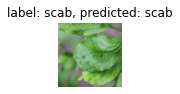

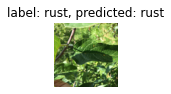

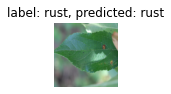

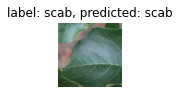

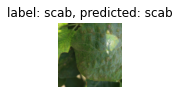

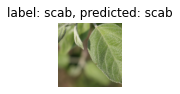

In [27]:
# ファインチューニング
# resnet18、出力は4クラスに変更
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(model_ft, dataloaders, class_names, device)

Epoch 0/24
----------
train Loss: 1.1474 Acc: 0.5026
val Loss: 0.8580 Acc: 0.7312
Epoch 1/24
----------
train Loss: 0.7484 Acc: 0.7761
val Loss: 0.6752 Acc: 0.7923
Epoch 2/24
----------
train Loss: 0.6377 Acc: 0.8171
val Loss: 0.6209 Acc: 0.8228
Epoch 3/24
----------
train Loss: 0.5871 Acc: 0.8127
val Loss: 0.5798 Acc: 0.7923
Epoch 4/24
----------
train Loss: 0.5329 Acc: 0.8415
val Loss: 0.5449 Acc: 0.8289
Epoch 5/24
----------
train Loss: 0.4876 Acc: 0.8493
val Loss: 0.5598 Acc: 0.8208
Epoch 6/24
----------
train Loss: 0.4842 Acc: 0.8484
val Loss: 0.5099 Acc: 0.8411
Epoch 7/24
----------
train Loss: 0.4727 Acc: 0.8476
val Loss: 0.5037 Acc: 0.8330
Epoch 8/24
----------
train Loss: 0.4789 Acc: 0.8458
val Loss: 0.5173 Acc: 0.8269
Epoch 9/24
----------
train Loss: 0.4719 Acc: 0.8493
val Loss: 0.5178 Acc: 0.8493
Epoch 10/24
----------
train Loss: 0.4685 Acc: 0.8502
val Loss: 0.4899 Acc: 0.8574
Epoch 11/24
----------
train Loss: 0.4596 Acc: 0.8571
val Loss: 0.4924 Acc: 0.8391
Epoch 12/24
--

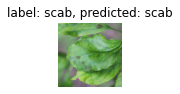

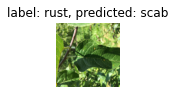

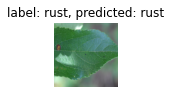

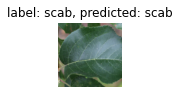

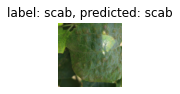

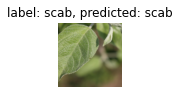

In [28]:
# 転移学習
model_conv = torchvision.models.resnet18(pretrained=True)

# 出力層以外のパラメータ固定
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)
visualize_model(model_conv, dataloaders, class_names, device)

In [29]:
# テストデータ
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
# ファインチューニング、予測
predict(model_ft, test_dataloader, columns)

                   precision    recall  f1-score   support

          healthy       0.91      0.96      0.93        52
multiple_diseases       0.67      0.50      0.57         8
             rust       0.98      0.95      0.97        62
             scab       0.93      0.95      0.94        60

         accuracy                           0.93       182
        macro avg       0.87      0.84      0.85       182
     weighted avg       0.93      0.93      0.93       182

[[50  0  0  2]
 [ 1  4  1  2]
 [ 1  2 59  0]
 [ 3  0  0 57]]


In [51]:
# 転移学習、予測
predict(model_conv, test_dataloader, columns)

                   precision    recall  f1-score   support

          healthy       0.80      0.87      0.83        52
multiple_diseases       1.00      0.12      0.22         8
             rust       0.88      0.92      0.90        62
             scab       0.83      0.83      0.83        60

         accuracy                           0.84       182
        macro avg       0.88      0.69      0.70       182
     weighted avg       0.85      0.84      0.83       182

[[45  0  3  4]
 [ 0  1  2  5]
 [ 4  0 57  1]
 [ 7  0  3 50]]


# 考察

## ファインチューニング or 転移学習
ファインチューニングと転移学習を両方試してみた結果、ファインチューニングで精度93%、転移学習で精度84%となった。
クラスごとのf1-scoreについてもすべてファインチューニングの方が上回っている。
どの層までパラメータの更新をさせるのが良いかは調査が必要だが、最終層以外も学習させる方針で進めてよいと思われる。

## クラスごとの評価指標
multiple_diseasesの評価指標が他のクラスに比べて著しく低い。
下記2点が原因ではないかと思われる。
1. multiple_diseasesクラスの画像枚数が少ない
2. 複数の病気に罹患しているため、そもそも特徴量の抽出が難しい

1については、実際にデータを観察して予想通りであるとわかった。

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: Target, dtype: int64


/home/ubuntu/anaconda3/envs/pytorch_p37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Target', ylabel='count'>

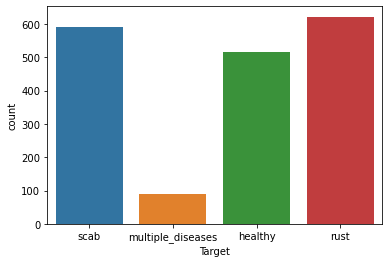

In [56]:
import seaborn as sns

targets = df["Target"].replace(dict(zip([0, 1, 2, 3], columns)))

print(targets.value_counts())
sns.countplot(targets)

## 今後の展望

以上から、multiple_diseasesが大きく足を引っ張っていることが分かった。
ネットワークの変更やハイパーパラメータに手を付ける前に、Under/OverSamplingで不均衡対策を行うべきと思われる。
今回の場合特に枚数差が顕著なので、下記論文にあるようなミニバッチ単位でUnderSamplingするアプローチなどを試すことも視野に入れたい。